## User Report

This notebook focuses on the data exploration and the training results.

In [14]:
import tensorflow as tf

import dlomix 
from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance
from dlomix.data import load_processed_dataset
from dlomix.constants import ALPHABET_NAIVE_MODS

from collections import Counter
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

### Load Dataset and Model

In [15]:
# Model directory and run name 
DATASET_DIR = '/cmnfs/proj/bmpc_dlomix/datasets/processed/noptm_baseline_small_bs1024_unmod_extended'
MODEL_DIR = '/cmnfs/proj/bmpc_dlomix/models/baseline_models/noptm_baseline_full_bs1024_naivemods/d961f940-d142-4102-9775-c1f8b4373c91'
LOGGING_DIR = '/nfs/home/students/s.baier/mapra/dlomix/bmpc_shared_scripts/refinement_transfer_learning/results_log/'
ALPHABET = ALPHABET_NAIVE_MODS

In [16]:
# Load the model
model = tf.keras.models.load_model(
    MODEL_DIR + '.keras', 
    custom_objects={'masked_spectral_distance': dlomix.losses.masked_spectral_distance}
    )

# check performance of model on the test set without modifications
eval_dataset = load_processed_dataset(DATASET_DIR)

### Data exploration

In [17]:
def plot_amino_acid_distribution(dataset_dict, alphabet, datasets=['train', 'val', 'test']):
    """
    Plots the frequency of each amino acid in the sequences for train, val, and test sets.
    """
    def count_amino_acids(sequences):
        aa_counts = {aa: 0 for aa in alphabet}
        for seq in sequences:
            for aa in seq:
                if aa in aa_counts:
                    aa_counts[aa] += 1
        return list(aa_counts.values())

    alphabet_keys = list(alphabet.keys())  # Ensure alphabet is a list of keys
    fig, axes = plt.subplots(len(datasets), 1, figsize=(18, 10), sharey=True)
    for i, dataset in enumerate(datasets):
        sequences = dataset_dict[dataset]['_parsed_sequence']
        aa_counts = count_amino_acids(sequences)
        axes[i].bar(alphabet_keys, aa_counts, edgecolor='black')
        axes[i].set_title(f'{dataset.capitalize()} Set')
        axes[i].set_xlabel('Amino Acid')
        axes[i].set_ylabel('Frequency')
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    plt.tight_layout()
    plt.show()
    
def plot_distribution(dataset_dict, datasets, feature, transform_func=None, bins=None, xlabel='', ylabel='Frequency', is_sequence=False):
    """
    General function to plot distributions for different features.
    """
    num_datasets = len(datasets)
    fig, axes = plt.subplots(1, num_datasets, figsize=(18, 5), sharey=True)
    
    for i, dataset in enumerate(datasets):
        data = dataset_dict[dataset][feature]
        if transform_func:
            data = transform_func(data)
        if is_sequence:
            data = [len(seq) for seq in data]
        
        actual_bins = bins(data) if callable(bins) else bins if bins is not None else 30
        axes[i].hist(data, bins=actual_bins, edgecolor='black')
        axes[i].set_title(f'{dataset.capitalize()} Set')
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)
        
    plt.tight_layout()
    plt.show()


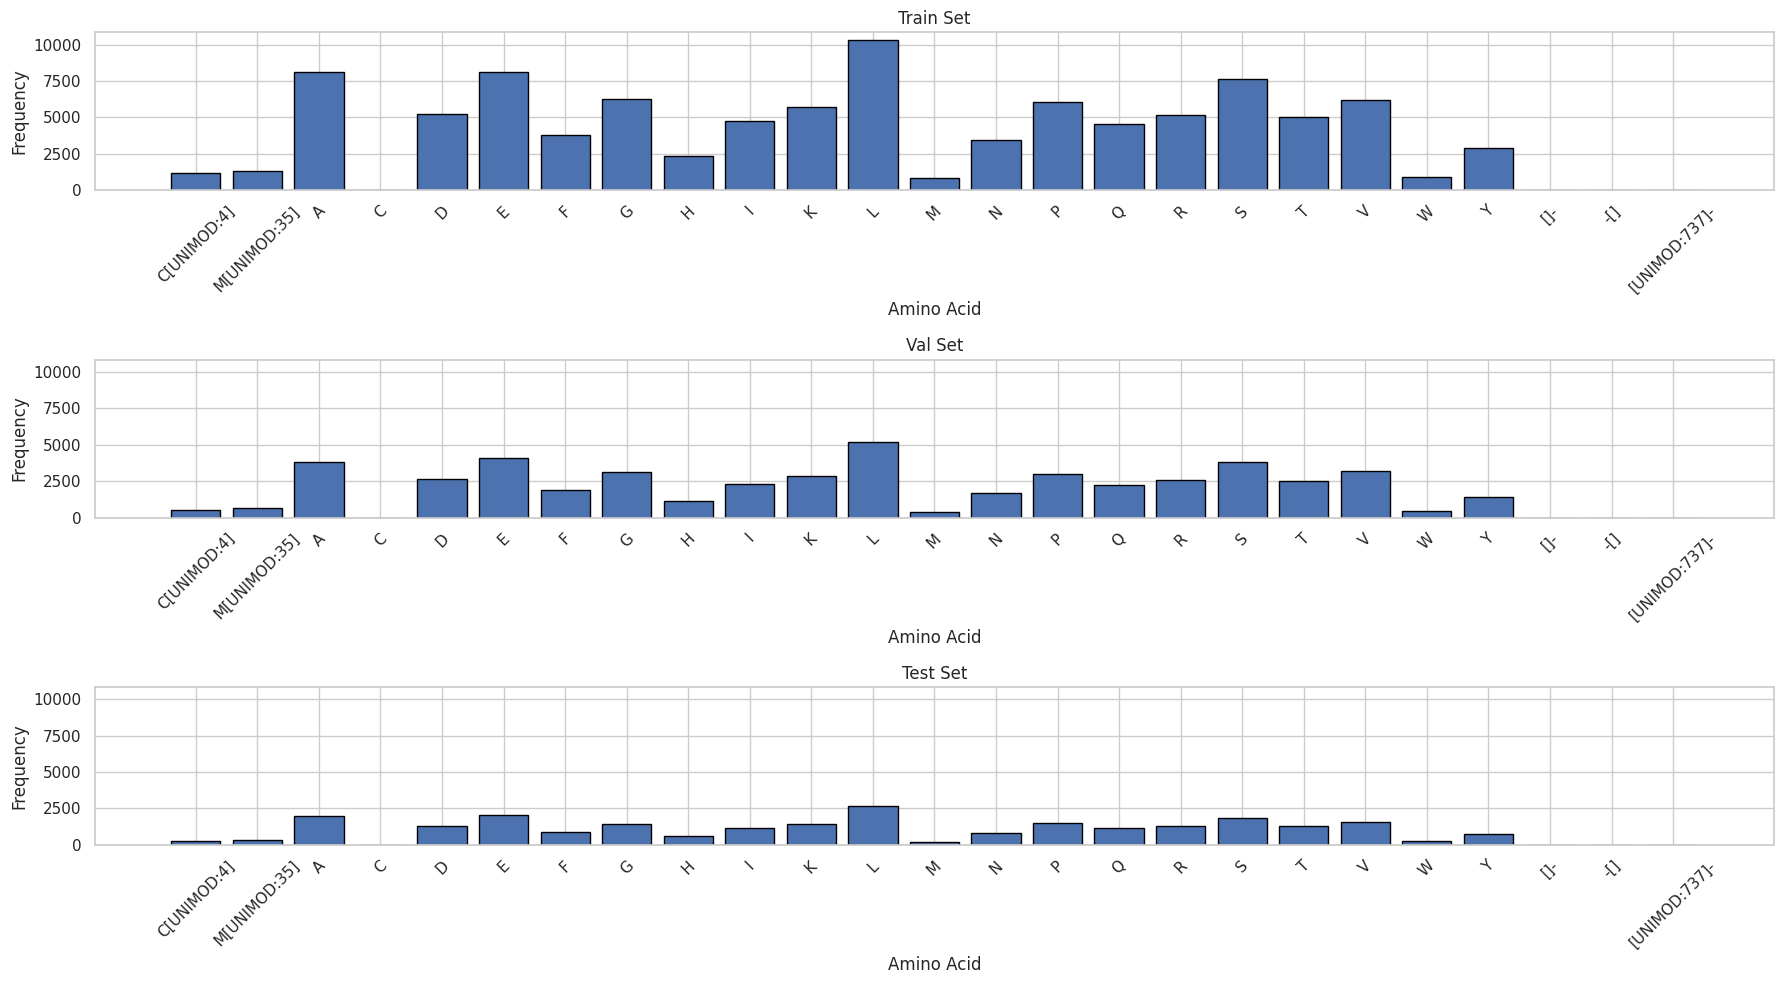

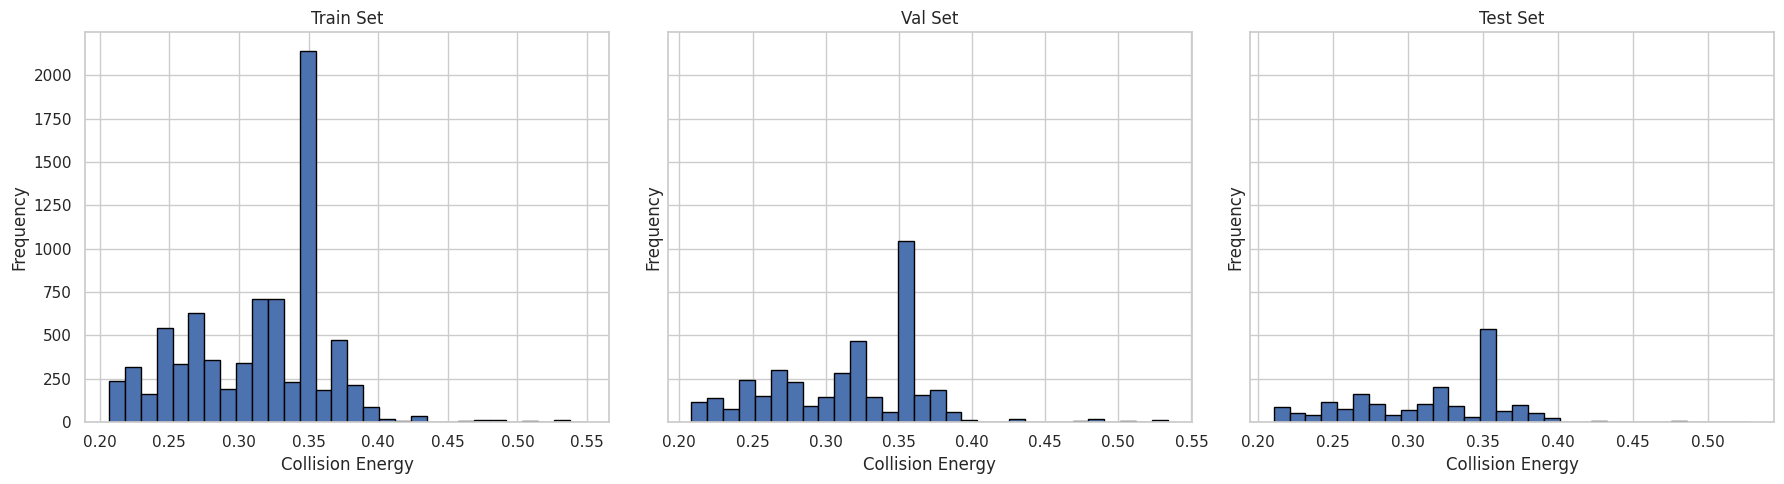

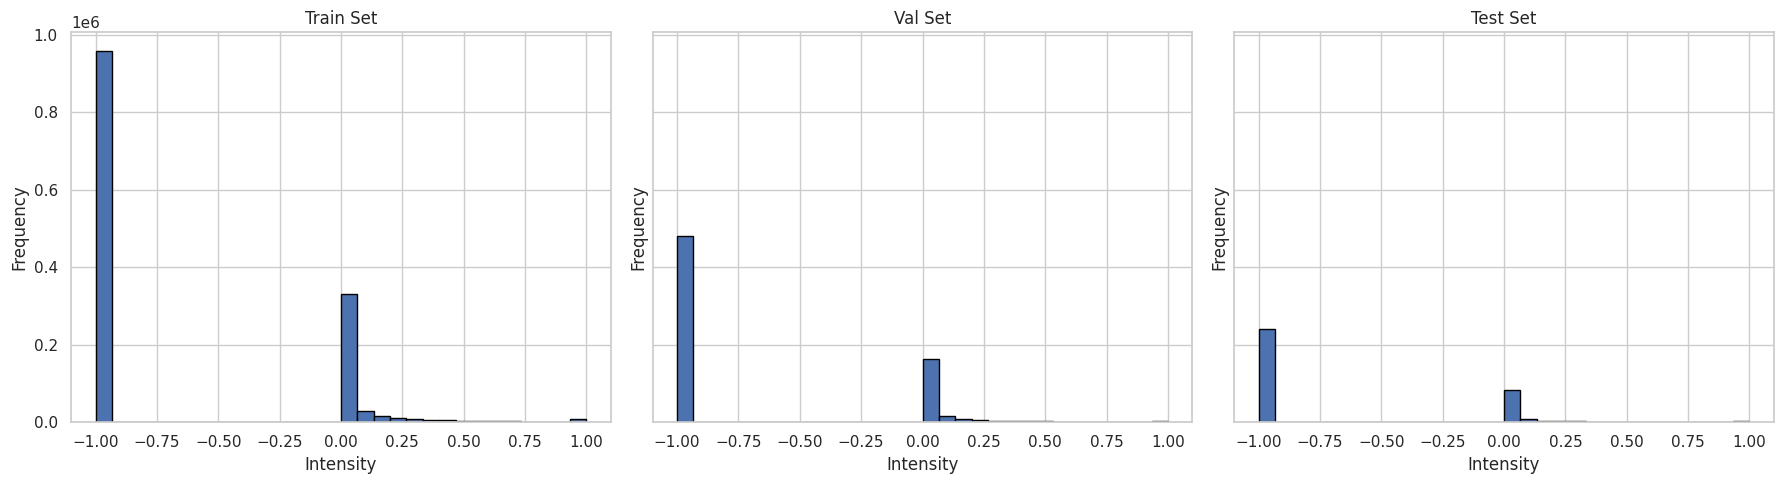

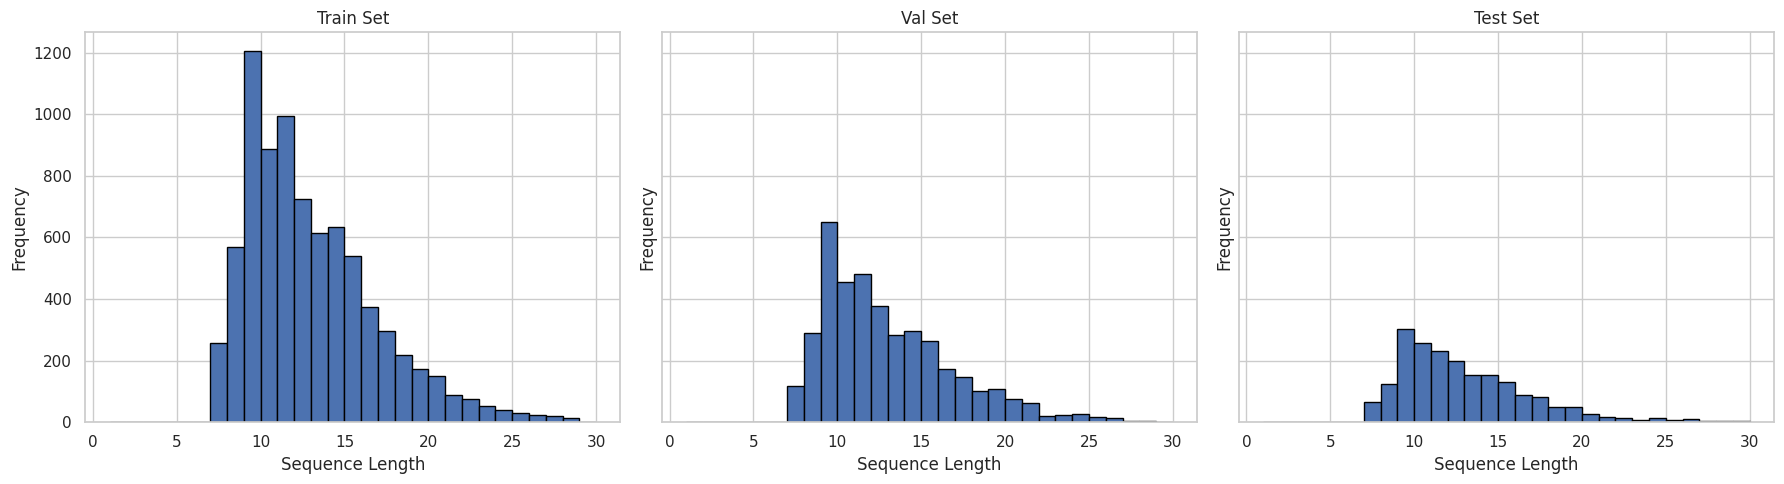

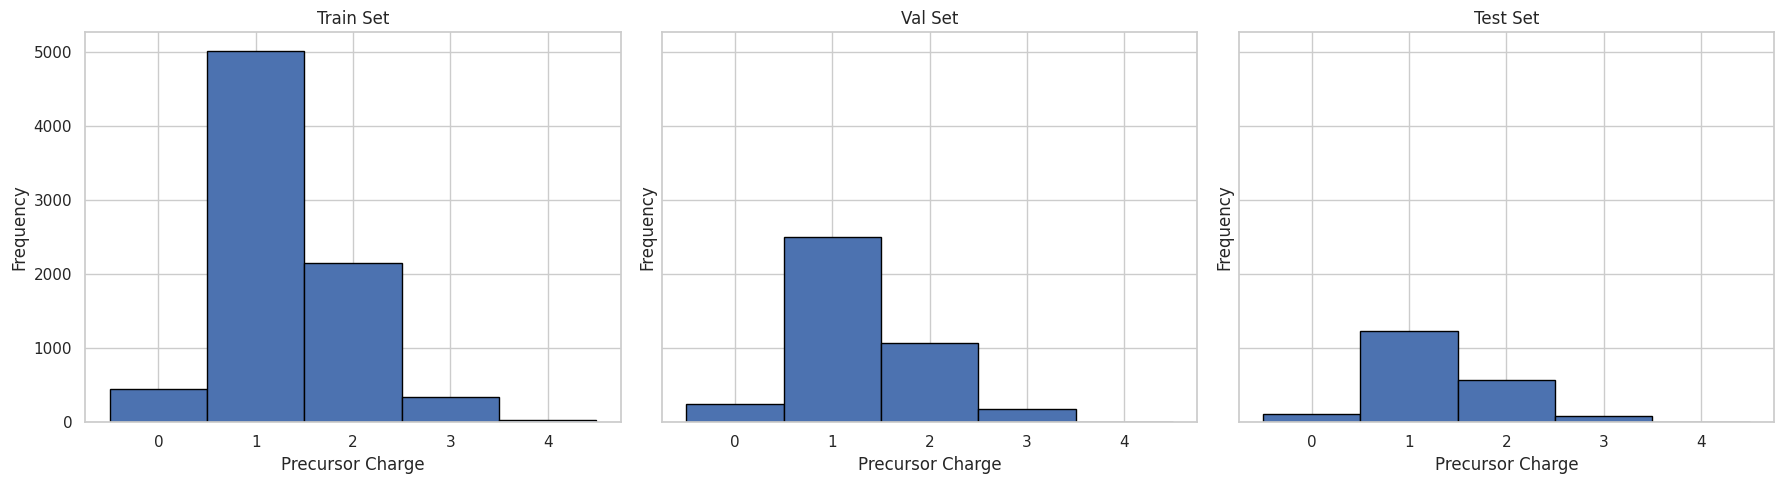

In [18]:
# Precompute bins for sequence length distribution
sequence_lengths = [len(seq) for dataset in ['train', 'val', 'test'] for seq in eval_dataset[dataset]['_parsed_sequence']]
max_length = max(sequence_lengths)
sequence_bins = range(1, max_length + 1)

# Plot distributions
plot_amino_acid_distribution(eval_dataset, ALPHABET, ['train', 'val', 'test'])
plot_distribution(eval_dataset, ['train', 'val', 'test'], 'collision_energy_aligned_normed', xlabel='Collision Energy')
plot_distribution(eval_dataset, ['train', 'val', 'test'], 'intensities_raw', lambda x: [i for sub in x for i in sub], xlabel='Intensity')
plot_distribution(eval_dataset, ['train', 'val', 'test'], '_parsed_sequence', is_sequence=True, bins=sequence_bins, xlabel='Sequence Length')
plot_distribution(eval_dataset, ['train', 'val', 'test'], 'precursor_charge_onehot', lambda x: np.argmax(x, axis=1), bins=np.arange(6) - 0.5, xlabel='Precursor Charge')

### Training results

##### Spectral Angle Distribution

In [19]:
def calculate_and_plot_spectral_angle_distribution(data, model, datasets=['train', 'val', 'test'], text_position=(0.2, 100)):
    """
    Predict the intensities, calculate spectral distances, and plot the spectral angle distribution for the specified datasets.

    Args:
        data: A dataset containing tensor_train_data, tensor_val_data, and tensor_test_data.
        model: A trained model used for making predictions.
        datasets: A list of strings indicating which datasets to use ('train', 'val', 'test').
        text_position: A tuple indicating the position of the average spectral angle text on the plot.

    Returns:
        None
    """
    def calculate_spectral_distance(dataset):
        spectral_dists = list()
        for batch, y_true in dataset:        
            y_pred = model.predict(batch)
            spectral_dists.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())
        return spectral_dists

    def plot_spectral_angle_distribution(spectral_dists, title, text_position):
        sa_data = [1 - sd for sd in spectral_dists]
        avg_sa = np.mean(sa_data)
        p = sns.histplot(sa_data)
        p.text(text_position[0], text_position[1], f'Avg. SA = {avg_sa:.2f}')
        plt.title(title)
        plt.xlabel('Spectral Angle')
        plt.tight_layout()
        plt.show()

    for dataset in datasets:
        if dataset == 'train':
            dataset_data = data.tensor_train_data
        elif dataset == 'val':
            dataset_data = data.tensor_val_data
        elif dataset == 'test':
            dataset_data = data.tensor_test_data
        else:
            raise ValueError("Invalid dataset type. Choose 'train', 'val', or 'test'.")

        spectral_dists = calculate_spectral_distance(dataset_data)
        plot_spectral_angle_distribution(spectral_dists, f'{dataset.capitalize()} Set', text_position)


26/26 [==============================] - 3s 93ms/step


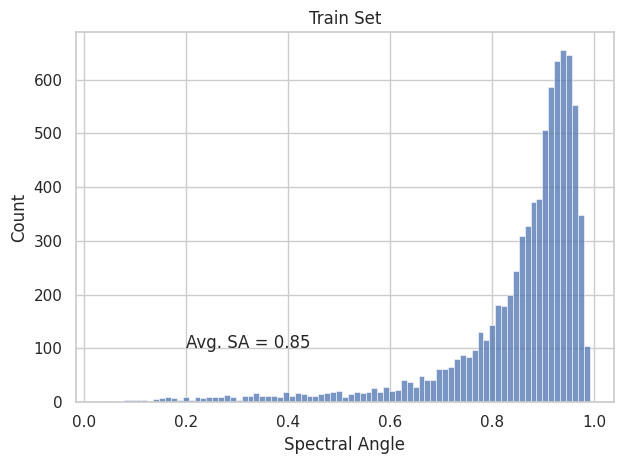

29/29 [==============================] - 3s 91ms/step


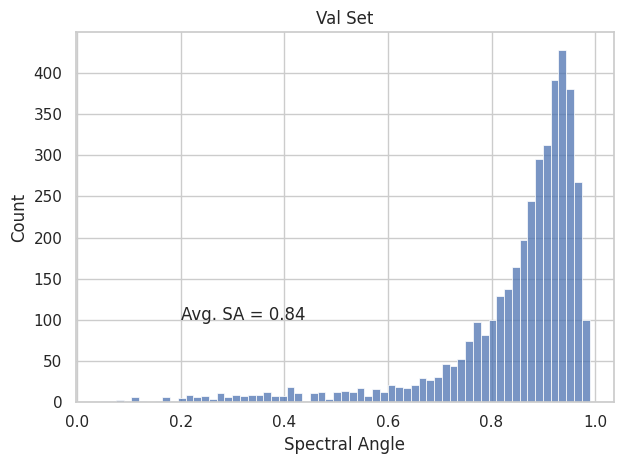

31/31 [==============================] - 3s 91ms/step


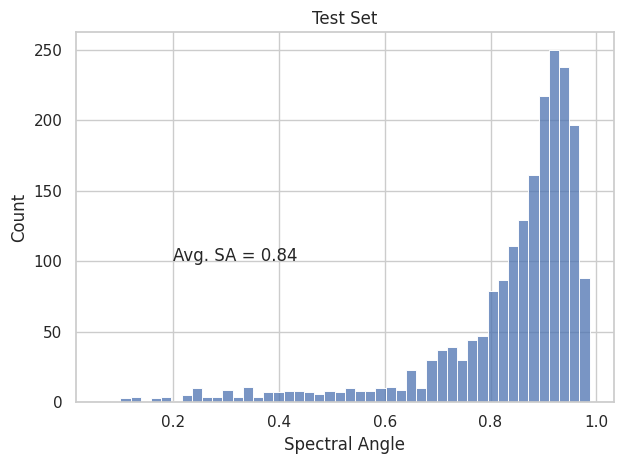

In [20]:
calculate_and_plot_spectral_angle_distribution(eval_dataset, model, ['train', 'val', 'test'])

### Pearson Correlation Distance


In [21]:
def calculate_pearson_correlation_distance(data, model, datasets=['train', 'val', 'test']):
    """
    Predict the intensities and calculate Pearson correlation distance between predictions and true intensities for specified datasets.

    Args:
        data: A dataset containing tensor_train_data, tensor_val_data, and tensor_test_data.
        model: A trained model used for making predictions.
        datasets: A list of strings indicating which datasets to use ('train', 'val', 'test').

    Returns:
        pearson_dists_dict: A dictionary with dataset names as keys and lists of Pearson correlation distances for each batch as values.
    """
    def calculate_distance_for_dataset(dataset):
        pearson_dists = []
        for batch, y_true in dataset:        
            y_pred = model.predict(batch)
            pearson_dist = masked_pearson_correlation_distance(y_true=y_true, y_pred=y_pred).numpy()
            pearson_dists.append(pearson_dist)
        return pearson_dists

    pearson_dists_dict = {}
    
    for dataset_type in datasets:
        if dataset_type == 'train':
            dataset_data = data.tensor_train_data
        elif dataset_type == 'val':
            dataset_data = data.tensor_val_data
        elif dataset_type == 'test':
            dataset_data = data.tensor_test_data
        else:
            raise ValueError("Invalid dataset type. Choose 'train', 'val', or 'test'.")
        
        pearson_dists_dict[dataset_type] = calculate_distance_for_dataset(dataset_data)
    
    return pearson_dists_dict


In [22]:
pearson_corr_dists = calculate_pearson_correlation_distance(eval_dataset, model, ['train', 'val', 'test'])
for dataset_type, distances in pearson_corr_dists.items():
    avg_distance = np.mean(distances)
    print(f'Average Pearson Correlation distance for {dataset_type}: {avg_distance}')

31/31 [==============================] - 3s 90ms/step
Average Pearson Correlation distance for train: 0.19388386607170105
Average Pearson Correlation distance for val: 0.18622024357318878
Average Pearson Correlation distance for test: 0.19152450561523438


#### Training process evaluation

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def identify_phase_transitions(data):
    """
    Identifies the start of new phases by detecting when the epoch resets to 0.
    Returns a list of indices where the new phases start.
    """
    return data.index[data['epoch'] == 0].tolist()

def plot_data(data):
    """
    Plots all columns in the provided DataFrame using seaborn, indicating the start of new phases.
    """
    sns.set_theme(style="whitegrid")
    num_plots = len(data.columns) - 2  
    fig, axes = plt.subplots(nrows=(num_plots + 1) // 2, ncols=2, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    phase_transitions = identify_phase_transitions(data)
    colors = ['blue', 'darkorange', 'green']

    axes = axes.flatten()
    for idx, column in enumerate(data.columns[1:6]):  
        sns.lineplot(ax=axes[idx], data=data, x='real_epochs', y=column)
        for i, pt in enumerate(phase_transitions):
            axes[idx].axvline(x=pt, color=colors[i % len(colors)], linestyle='--', alpha=0.5, label=f'Phase {i+1}')
        pretty_column_name = column.replace("_", " ")
        axes[idx].set_title(f'{pretty_column_name.title()} vs epochs')
        axes[idx].set_xlabel('epochs')
        axes[idx].set_ylabel(pretty_column_name)

    # Remove extra axes if any
    for i in range(len(data.columns) - 2, len(axes)):  
        fig.delaxes(axes[i])

    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center')

    plt.show()


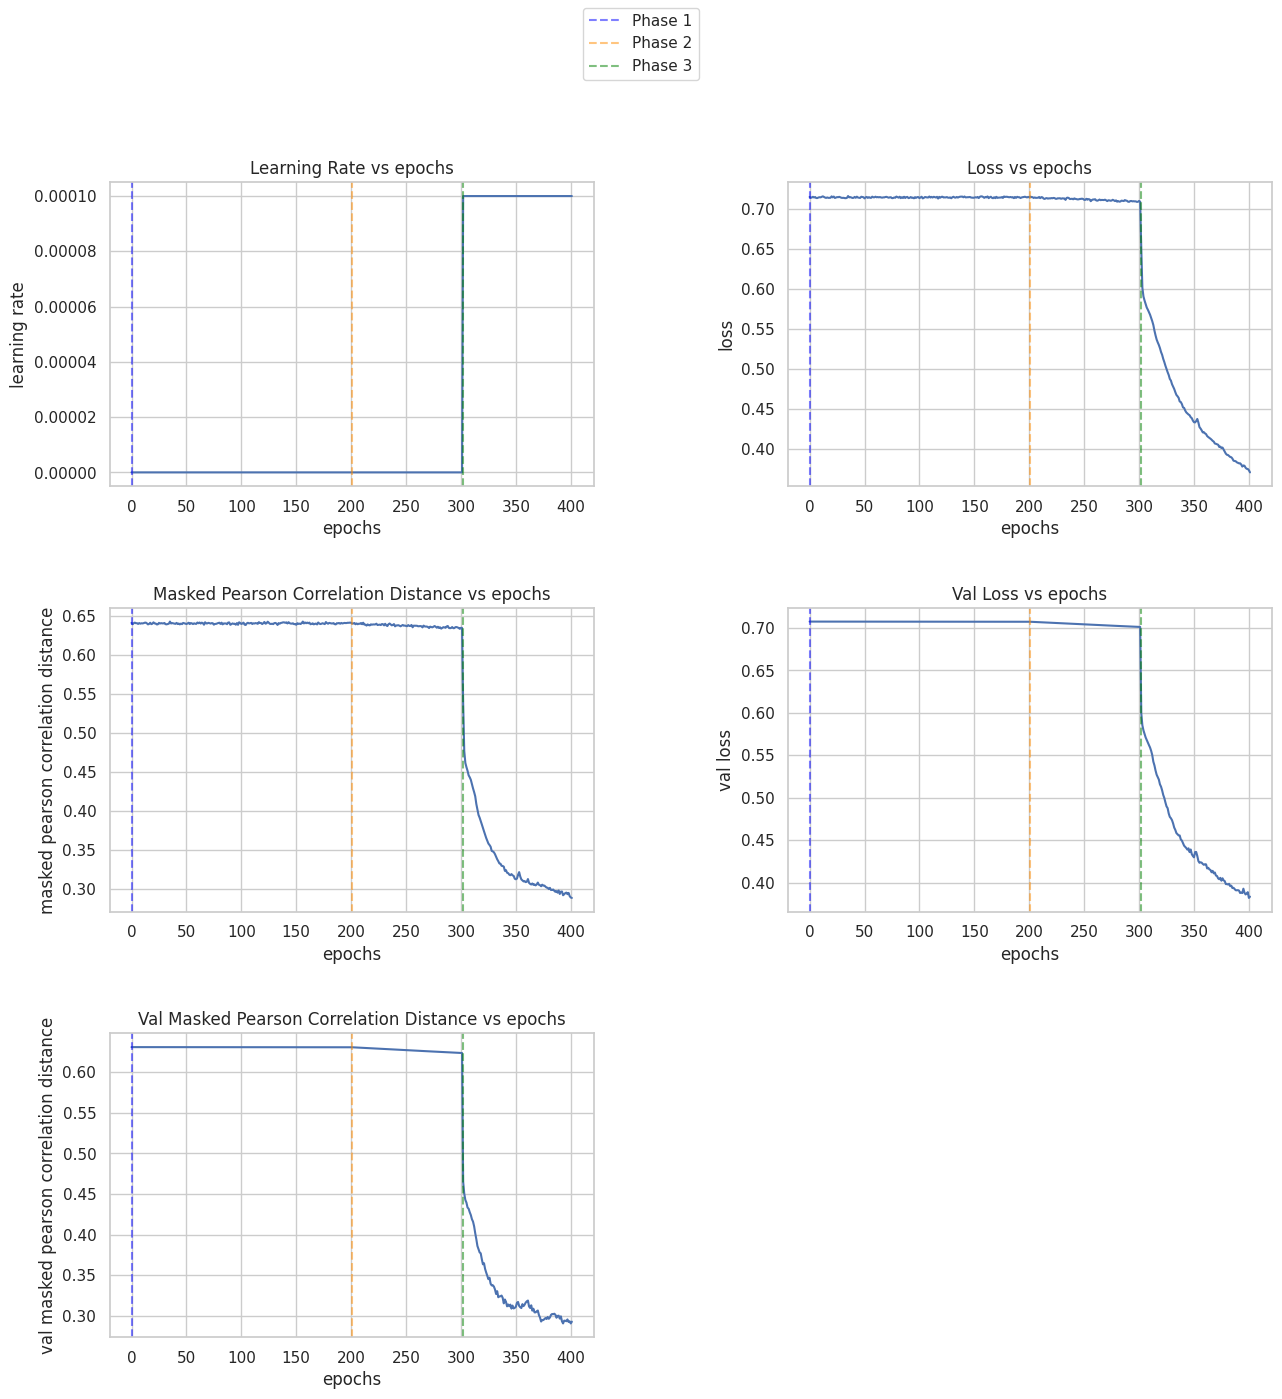

In [31]:
logged_training_results = pd.read_csv(f'{LOGGING_DIR}training_log.csv')
logged_training_results['real_epochs'] = range(logged_training_results.shape[0])
plot_data(logged_training_results)

Freezing per phase

In [25]:
logged_freezing = pd.read_csv(f'{LOGGING_DIR}freeze_log.csv', header=None, names=["freezing", "status"], skip_blank_lines=False)
logged_freezing['Phase'] = logged_freezing['freezing'].isna().cumsum() + 1
logged_freezing = logged_freezing.dropna().reset_index(drop=True)
logged_freezing['Phase'] = logged_freezing['Phase'].apply(lambda x: f"Phase {x}")
logged_freezing['status'] = logged_freezing['status'].astype(int)
logged_freezing

,freezing,status,Phase
0,freeze_old_embedding_weights,0,Phase 1
1,freeze_old_regressor_weights,0,Phase 1
2,freeze_inner_layers,1,Phase 1
3,freeze_embedding_layer,0,Phase 1
4,freeze_regressor_layer,1,Phase 1
5,freeze_old_embedding_weights,0,Phase 2
6,freeze_old_regressor_weights,0,Phase 2
7,freeze_inner_layers,0,Phase 2
8,freeze_embedding_layer,0,Phase 2
9,freeze_regressor_layer,0,Phase 2
